# Finding commensurate roots

In many applications the poles of the transfer function can be found by solving a polynomial. If the denominator is a polynoamial in $x = exp(-zT_{\text{lcm}})$ for some delay $T_{\text{lcm}}$ then this can be done. In the more general case network when the delays $T_1,...,T_n$ are not commensurate, a different method is needed, such as the root-finding algorithm implemented in Roots.py. Here we show how from the commensurate delays we can find roots in a desired frequency range.

In [1]:
import numpy as np

In [7]:
import Potapov_Code.Time_Delay_Network as networks

In [ ]:
import matplotlib.pyplot as plt
%pylab inline

In [586]:
import sympy as sp
from sympy import init_printing
init_printing() 

In [303]:
from fractions import gcd

In [304]:
## To identify commensurate delays, we must use a decimal and NOT a binary representation of the delays,
## as done by standard python floats/longs

from decimal import Decimal

In [305]:
X = networks.Example3()

In [306]:
X.delays

[0.1, 0.23, 0.1, 0.17]

## get gcd for a list of integers

In [307]:
def gcd_lst(lst):
    l = len(lst)
    if l == 0:
        return None
    elif l == 1:
        return lst[0]
    elif l == 2:
        return gcd(lst[0],lst[1])
    else:
        return gcd(lst[0],gcd_lst(lst[1:]))

## testing

In [308]:
gcd_lst([1,2,3,4,5,6])

1

In [309]:
gcd_lst([2,4,8,6])

2

In [310]:
gcd_lst([3,27,300,6])

3

## find the shortest commensurate delay

In [196]:
def find_commensurate(delays):
    mult = min([d.as_tuple().exponent for d in delays])
    power = 10**-mult
    delays = map(lambda x: x*power,delays)
    int_gcd = gcd_lst(delays)
    return int_gcd/power

## testing

In [223]:
delays = [Decimal('1.14'),Decimal('532.23423'),Decimal('0.06'),Decimal('0.1')]

In [312]:
lcm = find_commensurate(delays)
lcm

Decimal('0.00001')

In [313]:
map(lambda z: z / lcm, delays)

[Decimal('1.14E+5'), Decimal('53223423'), Decimal('6E+3'), Decimal('1E+4')]

In [350]:
## in general converting floats to Decimal shoudl be avoided because floats are stored in binary form.
## converting to a string first will round the number.
## Good practice would be to specify the delays in Decimals, then convert to floats later.

lcm = find_commensurate(map(lambda x: Decimal(str(x)),X.delays)) 
lcm

Decimal('0.01')

In [585]:
Decimal_delays =map(lambda x: Decimal(str(x)),X.delays)
Decimal_delays

[Decimal('0.1'), Decimal('0.23'), Decimal('0.1'), Decimal('0.17')]

In [383]:
E = sp.Matrix(np.zeros_like(X.M1))

In [384]:
x = sp.symbols('x')

In [391]:
for i,delay in enumerate(Decimal_delays):
    E[i,i] = 1.*x**int(delay / lcm)

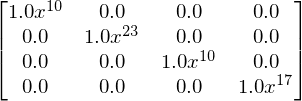

In [392]:
E

In [393]:
M1 = sp.Matrix(X.M1)

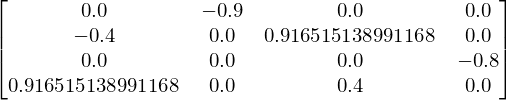

In [407]:
M1

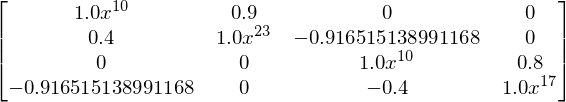

In [394]:
E - M1

In [410]:
expr = sp.apart((E - M1).det())

In [411]:
a = sp.Poly(expr, x)

In [414]:
a

In [417]:
poly_coeffs = a.all_coeffs()
poly_coeffs

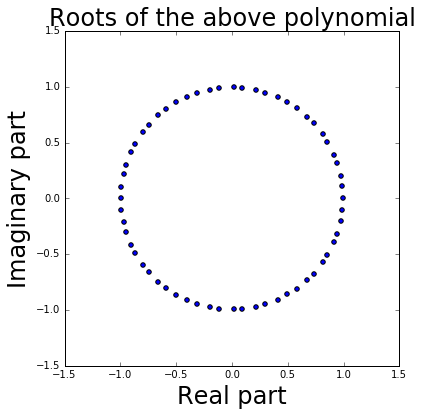

In [437]:
roots = np.roots(poly_coeffs)

plt.figure(figsize =(6,6))
fig = plt.scatter(roots.real,roots.imag)
plt.title('Roots of the above polynomial',{'fontsize':24})
plt.xlabel('Real part',{'fontsize':24})
plt.ylabel('Imaginary part',{'fontsize':24})

## Going from $x = exp(-zT_{\text{lcm}})$ to solutions z. (Note the sign convention!)

The roots repeat with a period of $2 \pi / T_{\text{lcm}} \approx 628$.

In [460]:
zs = np.asarray(map(lambda r: np.log(r) / - float(lcm), roots))

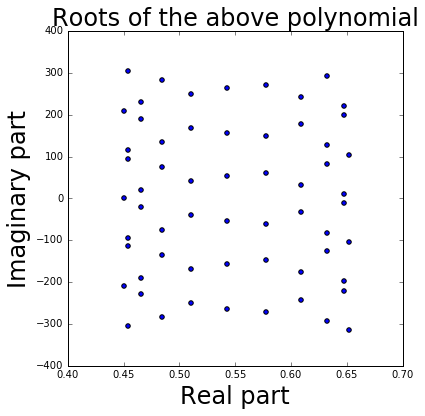

In [461]:
plt.figure(figsize =(6,6))
fig = plt.scatter(zs.real,zs.imag)
plt.title('Roots of the above polynomial',{'fontsize':24})
plt.xlabel('Real part',{'fontsize':24})
plt.ylabel('Imaginary part',{'fontsize':24})

In [555]:
def find_instances_in_range(z,freq_range):
    T = 2.*np.pi / float(lcm)
    if z.imag >= freq_range[0] and z.imag <= freq_range[1]:
        lst_in_range = [z]
        num_below = int((z.imag - freq_range[0])/T )
        num_above = int((freq_range[1] - z.imag)/T )
        lst_in_range += [z + 1j * disp for disp in (np.asarray(range(num_above))+1) * T]
        lst_in_range += [z - 1j * disp for disp in (np.asarray(range(num_below))+1) * T]
        return lst_in_range
    elif z.imag > freq_range[1]:
        min_dist = (int((z.imag - freq_range[1])/T)+1) * T
        max_dist = int((z.imag - freq_range[0]) / T) * T
        if min_dist > max_dist:
            return []
        else:
            return find_instances_in_range(z - 1j*min_dist,freq_range)
    else:
        min_dist = (int((freq_range[0] - z.imag)/T)+1) * T
        max_dist = int((freq_range[1] - z.imag)/T)  * T
        if min_dist > max_dist:
            return []
        else:
            return find_instances_in_range(z + 1j*min_dist,freq_range)  

In [556]:
z = zs[40]
z.imag

In [562]:
## test cases...

In [558]:
find_instances_in_range(z,(-3000,-1000))

[(0.65220723077943077-1151.9173063162575j),
 (0.65220723077943077-1780.2358370342163j),
 (0.65220723077943077-2408.5543677521746j)]

In [559]:
find_instances_in_range(z,(-3000,1000))

[(0.65220723077943077+104.71975511965982j),
 (0.65220723077943077+733.03828583761845j),
 (0.65220723077943077-523.59877559829886j),
 (0.65220723077943077-1151.9173063162575j),
 (0.65220723077943077-1780.235837034216j),
 (0.65220723077943077-2408.5543677521746j)]

In [560]:
find_instances_in_range(z,(3000,5000))

[(0.65220723077943077+3246.3124087094534j),
 (0.65220723077943077+3874.6309394274122j),
 (0.65220723077943077+4502.9494701453705j)]

In [561]:
find_instances_in_range(z,(3000,1000))

In [567]:
def find_roots_in_range(roots,freq_range):
    return np.concatenate([find_instances_in_range(r,freq_range) for r in roots])

In [571]:
roots_in_range = find_roots_in_range(zs,(-1000,1000))

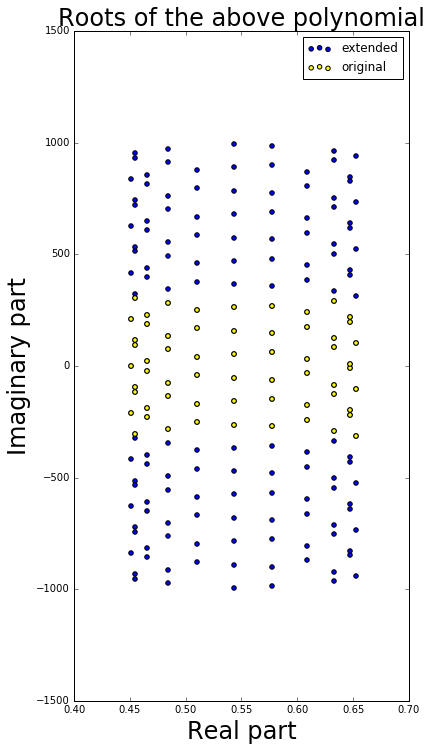

In [581]:
plt.figure(figsize =(6,12))
fig = plt.scatter(roots_in_range.real,roots_in_range.imag,label='extended')
plt.title('Roots of the above polynomial',{'fontsize':24})
plt.xlabel('Real part',{'fontsize':24})
plt.ylabel('Imaginary part',{'fontsize':24})
plt.scatter(zs.real,zs.imag,label='original',c='yellow')
plt.legend()

## Scaling of finding roots of polynomial using Python

The best we can hope for is $O(n^2)$ because this is a cost of an iteration in the QR algorithm, and ideally the number of iterations would not change much throughout the convergence process.

In [285]:
sample_pol_length = [10,50,100,1000,2000,3000]

In [274]:
import time

In [275]:
ts = [time.clock()]
for pol_length in sample_pol_length:
    pol = [0]*(pol_length+1)
    pol[0] = 1
    pol[pol_length] = 5
    np.roots(pol)
    ts.append(time.clock())

In [276]:
delta_ts = [ts[i+1]-ts[i] for i in range(len(ts)-1)]

[]

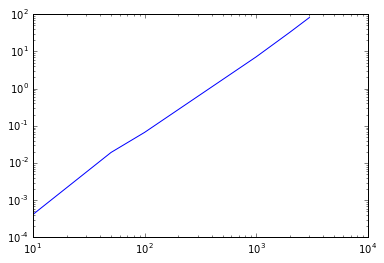

In [281]:
plt.plot(sort(sample_pol_length),sort(delta_ts))
plt.loglog()

## very roughly estimating the slope of the above log-log plot gives the exponent in $O(n^p)$.

In [300]:
(np.log(delta_ts[-1])-np.log(delta_ts[0])) / (np.log(sample_pol_length[-1]) - np.log(sample_pol_length[0]))

2.1371719506769975